<a href="https://colab.research.google.com/github/tunitskayaod/Homework/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_1_MNIST_%D0%BF%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D0%BE%D0%B8%CC%86_%D1%81%D0%B5%D1%82%D1%8C%D1%8E_PyTorch_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация MNIST полносвязной нейронной сетью

В этом практическом занятии мы рассмотрим задачу классификации изображений полносвязной нейронной сетью.

Мы будем решать классическую задачу распознавания рукописных цифр. Для этой задачи созан датасет MNIST. Он содержит в себе изображения (28x28 пикселей) рукописных цифр от 0 до 9 -- т.е. всего 10 классов картинок.

Далее посмотрим, как работает такая нейронная сеть для задачи распознавания изображений в датасетах CIFAR, которые являются набором реальных изображений, уменьшенных до размера 32x32 пикселей.

# Зафиксируйте генераторы случайных чисел

Генераторы случайных чисел генерируют различные наборы случайных чисел от запуска к запуску по умолчанию. Поскольку случайные числа используются для того, чтобы инициализировать веса сети и для того, чтобы выбирать примеры из обучающей выборки, то от запуска к запуску получившиеся нейронные сети будут отличаться.

Для того, чтобы решить эту проблему, необходимо инициализировать генераторы случайных чисел ```seed```-ами. Это делается следующими командами: ```random.seed``` для библиотеки ```random```, ```np.random.seed``` для библиотеки ```numpy```. Для pytirch же потребуется несколько команд:

```
torch.manual_seed_all
torch.cuda.manual_seed_all
```

Также потребуется переключить ```cuda``` в детерминированный режим:

```
torch.backends.cudnn.deterministic = True
```


In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

torch.backends.cudnn.deterministic = True

# YOUR CODE HERE

# Загрузите данные тренировочной и валидационной частей MNIST в память

Для этого используйте класс ```torchvision.datasets.MNIST```. Обратите внимание, что тренировочная и тестовая части задаются параметром ```train```.

In [ ]:
import torchvision

MNIST_train = torchvision.datasets.MNIST('.', train = True, download = True) # YOUR CODE HERE
MNIST_test = torchvision.datasets.MNIST('.', train = False, download = True)  # YOUR CODE HERE

# Проверяем, что все работает

In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

print(X_train.shape, y_train.shape, '<- train dataset X and y')
print(X_test.shape, y_test.shape, '<- test dataset X and y')

print(X_train.dtype, y_train.dtype, '<- training data type')

torch.Size([60000, 28, 28]) torch.Size([60000]) <- train dataset X and y
torch.Size([10000, 28, 28]) torch.Size([10000]) <- test dataset X and y
torch.uint8 torch.int64 <- training data type


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Приводим форматы

PyTorch по умолчанию работает с тензорами, состоящими из float значений. Соответственно, необходимо привести тензоры с данными к float при помощи метода тензора ```.float()```. В качестве лосс-функции мы будем использовать ```torch.nn.CrossEntropy```, которая принимает на вход предсказания нейронной сети и тензор из номеров верных классов. Этот тензор должен быть в формте ```long```. Поскольку по умолчанию ```y``` в датасете уже в формате ```long```, то ничего делать с метками уже не нужно.

In [ ]:
X_train = X_train.float() # YOUR CODE HERE
X_test = X_test.float() # YOUR CODE HERE

# Посмотрим на данные

Визуально оценим данные, которыми мы располагаем. Проверим, что разметка соответствует тому, что содержится на картинке. Для этого отобразим изображение при помощи ```plt.imshow``` и посмотрим, какой лейбл соответствует этому изображению.

Обратите внимание на этот код: в следующих заданиях делать отображения нужно будет самостоятельно.

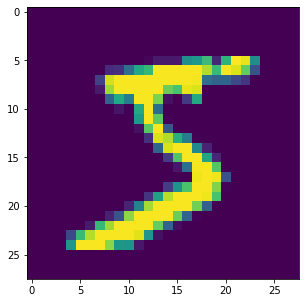

tensor(5)


In [ ]:
import matplotlib.pyplot as plt

index = 0

plt.imshow(X_train[index, :, :])
plt.show()
print(y_train[index])

# Подготовим нейронную сеть

Для того, чтобы сделать нейронную сеть, которую будем обучать, необходимо сделать класс, унаследованный от ```pytorch.nn.Module```, в котором будут две функции:

* ```__init__(self, n_hidden_neurons)``` -- конструктор, в котором определим модули, которые будем использовать в нейронной сети. Перед обьявлением модулей, необходимо инициализировать родительский класс при помощи ```super().__init__()```, после чего можно будет обьявлять необходимые модули
Нейронная сетьв нашем случае будет состоять всего из трех модулей. Схематически нейронную сеть можно представить следующим образом:
```
torch.nn.Linear 28*28 -> n_hidden_neurons
torch.nn.LeakyReLU
torch.nn.Linear n_hidden_heurons -> 10
```

* ```forward(self, x)``` -- прямой проход сети. Здесь необходимо из ```x``` получить прогнозы. ```x``` -- это батч из картинок, преобразованных в вектор. Батч -- тензор размера ```N x 784```, где ```N``` -- число изображений в батче, ```784``` -- число пикселей в черно-белом изображении ```28 x 28```. Примените ко входным данным ```x``` метод ```reshape([-1, 784])``` (```-1``` означает, что второе измерение должно быть размера 784, а первое -- чему получится). Затем последовательно примените модули, обьявленные в конструкторе и верните полученный сигнал.

In [ ]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        # YOUR CODE HERE
        super().__init__()
        self.linear1 = torch.nn.Linear(28*28 , n_hidden_neurons)
        self.act1 = torch.nn.LeakyReLU() 
        self.linear2 = torch.nn.Linear(n_hidden_neurons, 10)
    
    def forward(self, x):
        n = x.size(0) 
        res = x.reshape([n, -1]) 
        res = self.linear1(res)
        res = self.act1(res)
        res = self.linear2(res)
        return res
        # YOUR CODE HERE

# Проверим, что все сделано верно

In [ ]:
mnist_net = MNISTNet(100)
res = mnist_net(torch.zeros(10, 28*28))
assert res.shape[0] == 10
print(res.shape, '<- shape of predictions')


mnist_net.cuda()

torch.Size([10, 10]) <- shape of predictions


MNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

# Зададим лосс-функцию и оптимизатор

В качестве лосс-функции будем использовать ```torch.nn.CrossEntropyLoss```

В качестве оптимизатора будем использовать ```torch.nn.Adam```

Оптимизатор должен оптимизировать все параметры нейронной сети (ссылку на которые можно получить при помощи метода ```mnist_net.parameters()```) и скорость обучения необходимо выставить равной $10^{-3}$.

In [ ]:
loss = torch.nn.CrossEntropyLoss() # YOUR CODE HERE
optimizer = torch.optim.Adam(mnist_net.parameters(), 10**(-5)) # YOUR CODE HERE

# Сделаем процесс обучения

Все готово: оптимизатор, лосс-функция, нейронная сеть. Осталось обучить нейронную сеть.

Для этого нужно создать цикл обучения.

Цикл обучения обычно состоит из двух вложенных циклов: внутренний цикл обеспечивает проход по всем примерам из обучающей или тестовой выборки. Один такой проход называется эпохой.

Внешний же цикл обеспечивает повторение эпох.

# Инструкции по построению цикла обучения

* Сделайте внешний цикл из заранее заданного количества итераций, в котором:
  * Сгененрируйте случайный порядок следования обучающих примеров при помощи метода ```order = np.random.permutation(...)```
  * Сделайте внутренний цикл по обучающим примерам. Цикл должен терироваться по ```order``` с интервалом ```batch_size``` (```range(0, len(order), batch_size)```), в котором:
    * Получите индексы обучающих примеров для текущего шага, сделав слайсинг ```indice = order[start_index:start_index+batch_size]```.
    * Далее из обучающих примеров и лейблов нужно выбрать соответствующие примеры и лейблы при помощи индексации (```X_batch = X[indice]```).
    * Теперь мы готовы к тому, чтобы получить предсказания нейронной сети. Если вы используете батч-нормализации, то здесь нужно переключить сеть в тренировочный режим (```net.train()```)
    * Получите предсказания для полученного батча при помощи нейронной сети (```batch_preds = net(X_batch)```).
    * Рассчитайте значение лосс функции исходя из предсказаний и лейблов батча
    * Обнулите градиенты, накопленные в узлах нейронной сети, которые будут оптимизироваться (```optimizer.zero_grad()```).
    * Рассчитайте градиенты лосс-функции по параметрам нейронной сети ```loss.backward()```
    * Сделайте шаг оптимизатора (```optimizer.step()```).
    * Если вы используете батч-нормализации или DropOut, переключите нейронную сеть в валидационный режим (```net.valid()```).

  * Рассчитайте предсказания для тестовой выборки (в нашем случае это можно сделать одним батчем, ```test_preds = net(X_test)```)
  * Рассчитайте точность для тестовой выборки.
  * Рассчитайте лосс-функцию для тестовой выборки.
  * Добавьте рассчитанную точность в историю точности и лосс в историю лоссов


In [ ]:
batch_size = 100
n_epochs = 100

train_loss_history_batch = []

train_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
test_loss_history = []

for epoch in range(n_epochs):
  num_train_samples = X_train.shape[0]
  order = np.random.permutation(num_train_samples)
  X_train_c = X_train.clone()
  y_train_c = y_train.clone()
  X_train_o = X_train_c[order].cuda() 
  y_train_o = y_train_c[order].cuda()
  for batch_start in range(0, num_train_samples, batch_size ):
    X_batch = X_train_o[batch_start:batch_start + batch_size]
    y_batch = y_train_o[batch_start:batch_start + batch_size]

    optimizer.zero_grad()
    pred = mnist_net(X_batch)

    loss_val = loss(pred, y_batch)
    loss_val.backward()

    train_loss_history_batch.append(loss_val.detach())
  

    optimizer.step()

  with torch.no_grad():
    pred = mnist_net(X_train_o)
    pred_test = mnist_net(X_test.cuda())

    y_pred = pred.argmax(dim = 1)
    y_pred_test = pred_test.argmax(dim = 1)

    acc_train = (y_pred == y_train_o).float().sum()/len(y_train_o) #?
    acc_test = (y_pred_test == y_test.cuda()).float().sum()/len(y_test)

    loss_train = loss(pred,y_train_o)
    loss_test = loss(pred_test,y_test.cuda())

    train_loss_history.append(loss_train)
    train_accuracy_history.append(acc_train)

    test_loss_history.append(loss_test)
    test_accuracy_history.append(acc_test)


# YOUR CODE HERE



# Построим график прогресса обучения

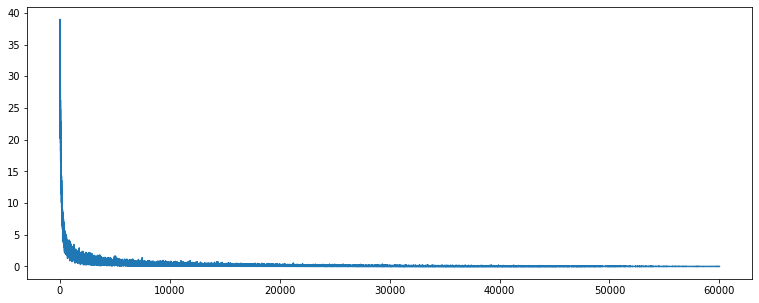

In [ ]:
plt.plot(train_loss_history_batch)

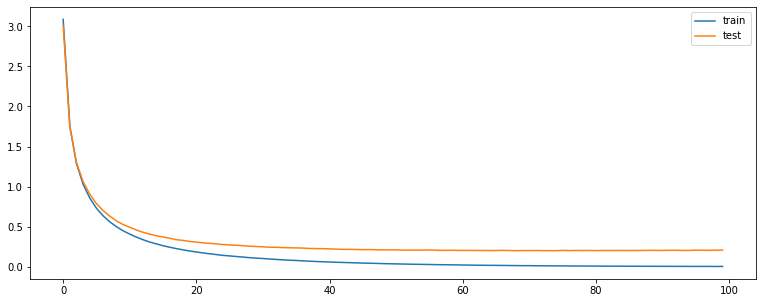

In [ ]:
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend(loc='upper right')

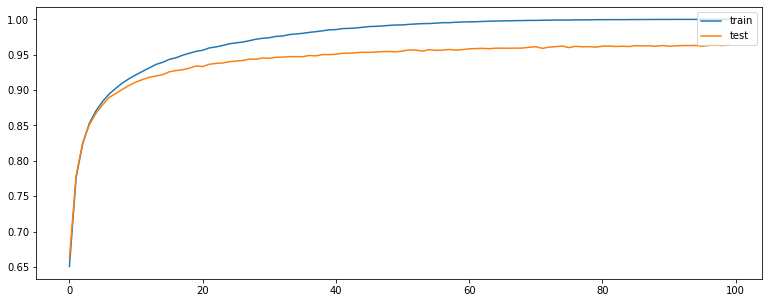

In [ ]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend(loc='upper right')

# Послесловие

Вы сделали ваш первый цикл обучения самостоятельно. Он довольно простой и лаконичный, занимает не больше 100 строк и его достаточно просто переписать. В этот цикл обучения можно добавлять все больше и больше функционала. В результате цикл обучения станет очень большим и нечитаемым, логику внутри цикла будет достаточно непросто понять.

Для того, чтобы не задумываться о циклах обучения, были разработаны библиотеки для упрощения обучения нейронных сетей такие, как PyTorch Lightning. Мы познакомимся с PyTorch Lightning в следующем практическом задании.